# Visual Question Answering

## Installing Libraries

In [ ]:
# conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
%pip install ftfy regex tqdm --user
%pip install git+https://github.com/openai/CLIP.git --user
%pip install pandas --user
%pip install wordcloud --user
%pip install sklearn --user
%pip install scikit-learn --user

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
import json
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

import modelArchitecture

## Global Variables

In [2]:
INPUT_PATH = 'vizwiz'
ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = ''
ANSWER_SPACE = 3129
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"

print("Device: ", DEVICE)

Device:  cpu


## Processing Data

In [83]:
def create_dataframe(path, type = 'train'):
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]

    # create a new DataFrame to hold the expanded rows
    expanded_df = pd.DataFrame(columns=df.columns)
    expanded_df.drop(columns=['answers'], inplace=True)
    
    # iterate over each row in the original DataFrame
    for index, row in df.iterrows():
        # iterate over each answer in the answers column
        for answer in row['answers']:
            # create a new row with the current answer
            new_row = row.copy()
            new_row['answer'] = answer['answer']
            new_row['answer_confidence'] = answer['answer_confidence'] #1 if answer['answer_confidence'] == 'yes' else 0.5 if answer['answer_confidence'] == 'maybe' else 0
            # add the new row to the expanded DataFrame
            expanded_df = pd.concat([expanded_df, pd.DataFrame(new_row).transpose()], ignore_index=True)
    return expanded_df

def read_dataframe(path):
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

def save_dataframe(dataframe, path, type = 'train'):

    path+= 'dataframes' if path =='' else '/dataframes'
    if not os.path.exists(path):
        os.makedirs(path)

    if type == 'train':
        dataframe.to_csv(path + '/train.csv', index=False)
    elif type == 'val':
        dataframe.to_csv(path + '/val.csv', index=False)
    else:
        dataframe.to_csv(path + '/test.csv', index=False)

def load_dataframe(path, type = 'train'):
    path+= 'dataframes' if path =='' else '/dataframes'
    if type == 'train':
        return pd.read_csv(path + '/train.csv')
    elif type == 'val':
        return pd.read_csv(path + '/val.csv')
    else:
        return pd.read_csv(path + '/test.csv')

def split_train_test(dataframe, test_size = 0.05):
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test


def plot_histogram(dataframe, column):
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()


def plot_boxplot(dataframe, column):
    plt.boxplot(dataframe[column])
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):

    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def explore_dataframe(dataframe):

    # let's see the distribution of the answer types
    plot_pie(dataframe, 'answer_type')

    # let's see the distribution of the answerable column
    plot_pie(dataframe, 'answerable')

    # let's plot histograms for the answerable column
    plot_histogram(dataframe, 'answerable')

    # let's see the distribution of the question column
    plot_wordcloud(dataframe, 'question')
    

def get_number_of_distinct_answers(dataframe):
    # Create a set to count the number of unique answers
    unique_answers_set = set()

    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

## Creating Dataframes & Splitting

In [86]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df)
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39515


## Exploratory Data Analysis

### Training Dataframe

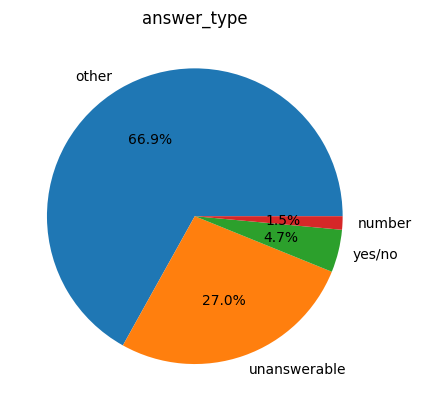

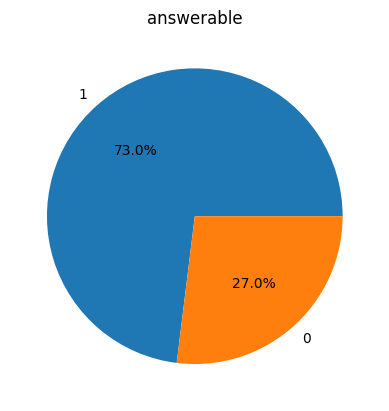

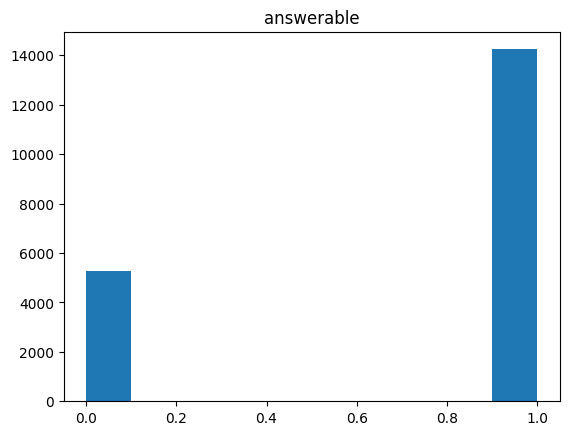

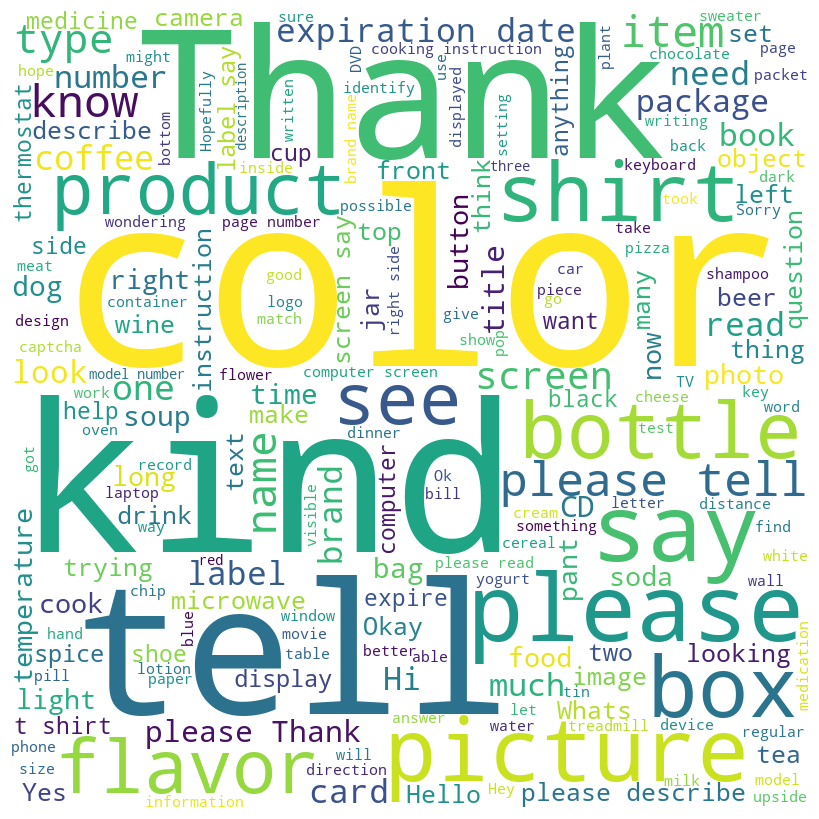

Number of distinct answers:  39515
Number of samples in train:  19496


In [91]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

### Validation Dataframe

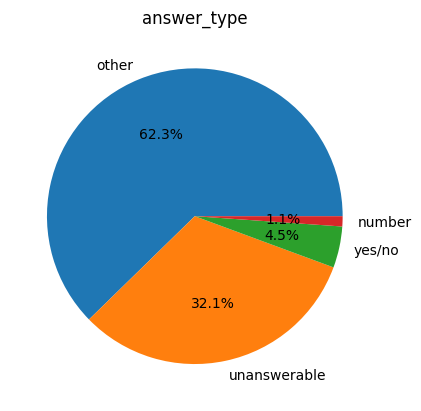

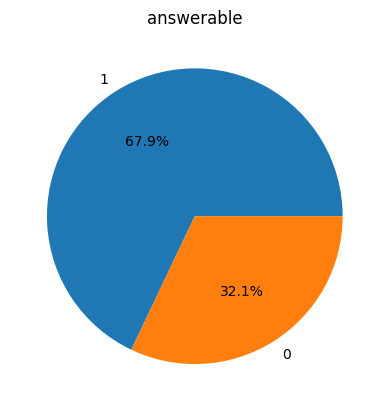

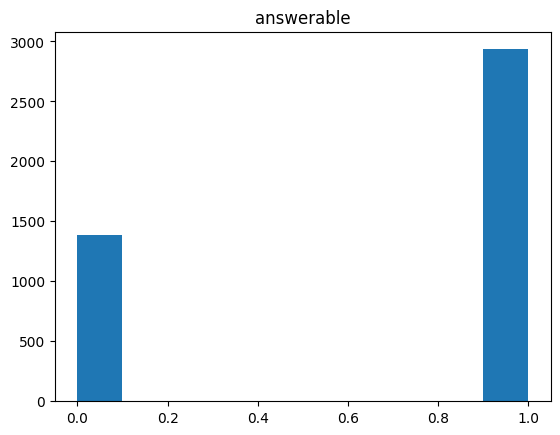

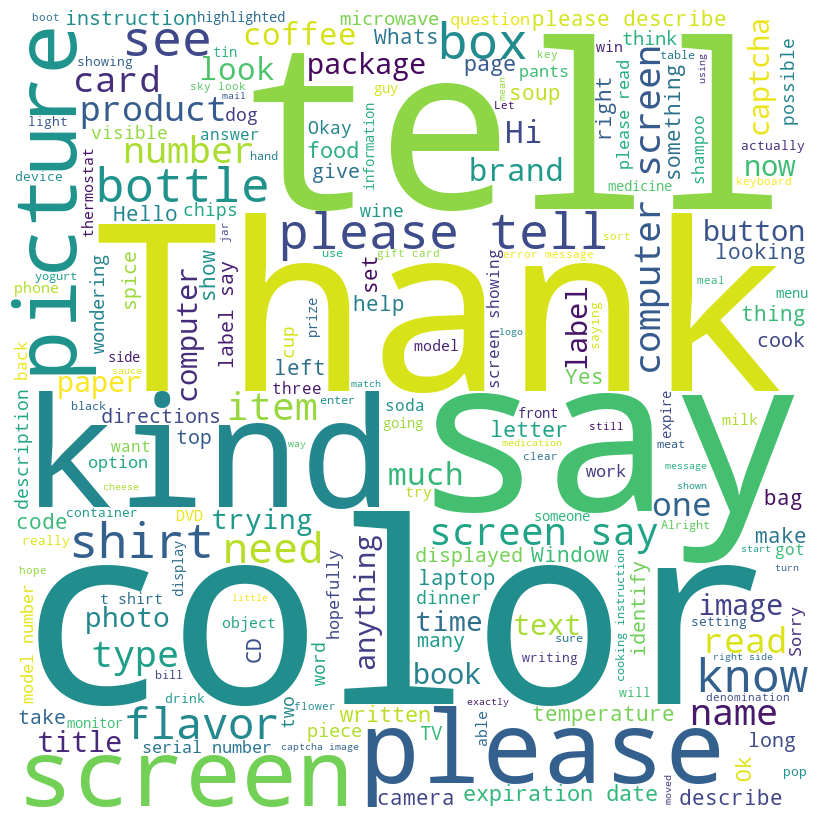

Number of distinct answers:  10905
Number of samples in validation set:  4319


In [92]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

### Testing Dataframe

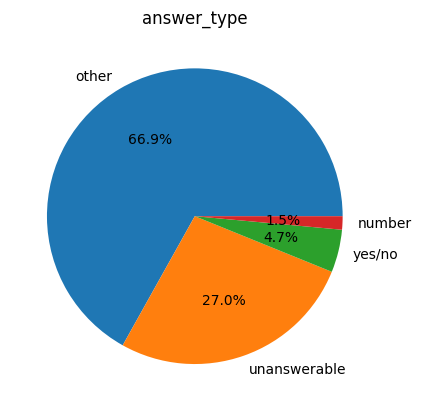

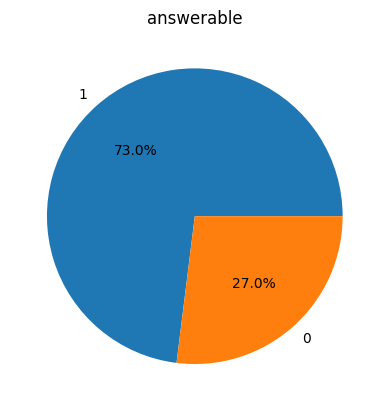

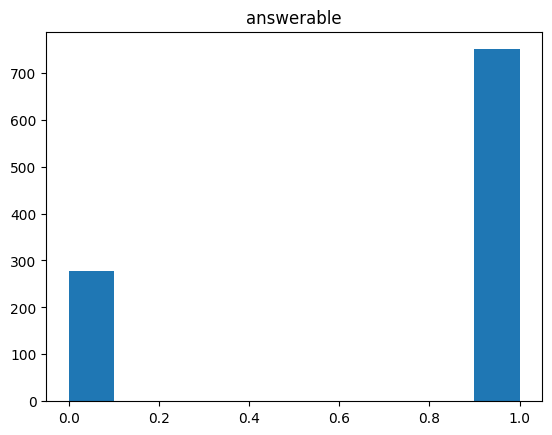

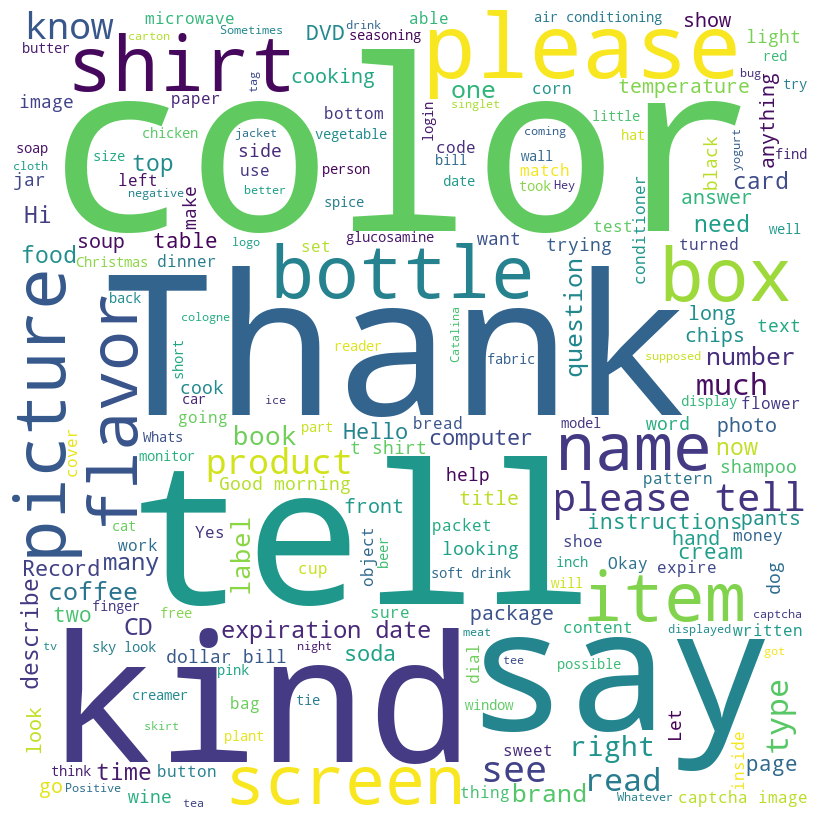

Number of distinct answers:  3007
Number of samples in test:  1027


In [93]:
explore_dataframe(test_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))

## Creating Model

In [ ]:
model = modelArchitecture.VQAModel(num_classes=10, device= DEVICE, hidden_size=512, model_name="RN50x4")

## Creating Dataset Class

In [ ]:
class VizWizDataset(torch.utils.data.Dataset):
    def __init__(self, data, path):
        self.data = data
        self.path = path
        self.transform = clip.load('ViT-B/32', device='cuda')
        self.tokenizer = clip.tokenize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.path + '/' + self.data[idx]['image']
        img = plt.imread(img_path)
        img = torch.tensor(img).permute(2, 0, 1)
        img = img / 255.0
        img = img.unsqueeze(0)
        img = img.to('cuda')
        text = self.data[idx]['question']
        text = self.tokenizer(text).to('cuda')
        return img, text

## Training Model